# Exploring the Spaceship titanic dataset

# Imports

#### Standard library imports

In [1]:
import sys
sys.path.append("../")
import os

#### Third party imports

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Local application imports

In [3]:
%load_ext autoreload
%autoreload 2

from pkg_dir.config import *
from pkg_dir.src.utils import *
from pkg_dir.src.functions import *
from pkg_dir.src.parameters import *

# Loading data
- Training dataset

In [4]:
dftr = pd.read_csv(data_training)

# Processing data based on the data schema

In [5]:
dftr = data_wrangling_schema_functions(dftr, titanicsp_data_schema)

# Individual features exploration

## PassengerId
A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.

### Groups of traveling passengers

In [ ]:
dfx = dftr['PassengerId'].str.split(pat='_', expand=True)

In [ ]:
dfx[0].value_counts()

This shows that the group information is quite scattered in many small groups (there are only 1,412 groups that have more than one person; 3,888 entries belong to these groups). Therefore, it might not be a good idea to use it as an additional feature.

### Relation between the group and the missing people
- Do people tend to disappear in groups? 

In [ ]:
dfx = pd.concat(
    [
        dftr['PassengerId'].str.split(pat='_', expand=True),
        dftr['Transported']
    ],
    axis=1,
)

In [ ]:
dfx2 = dfx[0].value_counts().to_frame()
lx = dfx2[dfx2[0] > 1].index

In [ ]:
dfx = dfx[dfx[0].isin(lx)].groupby(
    [
        dfx[0],
        dfx['Transported']
    ]
).agg(
    count=(1, 'count'),
)

## HomePlanet
The planet the passenger departed from, typically their planet of permanent residence.

### Count per category

In [7]:
dftr['HomePlanet'].value_counts(normalize=True)

Earth     0.529391
Europa    0.245140
Mars      0.202347
nan       0.023122
Name: HomePlanet, dtype: float64

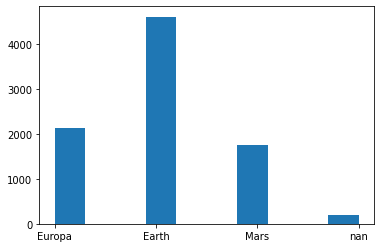

In [8]:
plt.hist(dftr['HomePlanet'])

plt.show()

### Missing values

*Note*

Maybe a good way to fill missing values is using the group information present in the id feature

## CryoSleep 
Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.


### Value counts

In [9]:
dftr['CryoSleep'].value_counts(normalize=True)

False    0.641694
True     0.358306
Name: CryoSleep, dtype: float64

## Cabin
The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.


### Separating column in components

In [19]:
dfx = pd.concat(
    [
        dftr['Cabin'].str.split(pat='/', expand=True),
        dftr['Transported'],
    ],
    axis=1
)

### Deck

In [21]:
dfx[0].value_counts(normalize=True)

F      0.321408
G      0.294375
E      0.100771
B      0.089612
C      0.085931
D      0.054987
A      0.029449
nan    0.022892
T      0.000575
Name: 0, dtype: float64

### Number

In [13]:
dfx[1].value_counts(normalize=True)

82      0.003296
86      0.002590
19      0.002590
56      0.002472
176     0.002472
          ...   
1644    0.000118
1515    0.000118
1639    0.000118
1277    0.000118
1894    0.000118
Name: 1, Length: 1817, dtype: float64

**Note**

This value is highly fragmented and might not be of relevance

### Side

In [14]:
dfx[2].value_counts(normalize=True)

S    0.504827
P    0.495173
Name: 2, dtype: float64

In [34]:
dfx2 = dfx.groupby(
    [
        dfx[2],
        dfx['Transported'],
    ],
    as_index=False
).agg(
    count=(0, 'count')
)

dfx2['count_prop'] = dfx2['count'] / dfx2.groupby(2)['count'].transform('sum')

dfx2

,2,Transported,count,count_prop
0,P,False,2308,0.548740
1,P,True,1898,0.451260
2,S,False,1908,0.444963
3,S,True,2380,0.555037


**Note**

This simple grouping suggests that there is no clear difference between people in 'S' or 'P'

## Destination
The planet the passenger will be debarking to.

In [36]:
dftr['Destination'].value_counts(normalize=True)

TRAPPIST-1e      0.680433
55 Cancri e      0.207063
PSO J318.5-22    0.091568
nan              0.020936
Name: Destination, dtype: float64

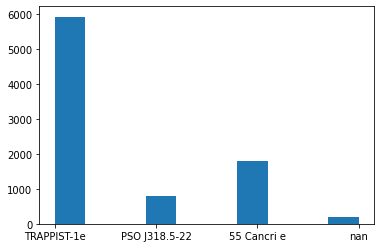

In [37]:
plt.hist(
    x=dftr['Destination']
)

plt.show()

## Age
The age of the passenger.

### Assessing if the ages are only integers

In [38]:
(dftr['Age'] - dftr['Age'].round(0)).unique()

array([ 0., nan])

### Analyzing the distribution of ages

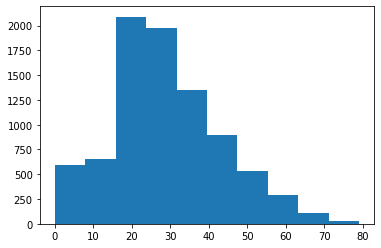

In [39]:
plt.hist(
    x=dftr['Age'],
)

plt.show()

## VIP
Whether the passenger has paid for special VIP service during the voyage.

In [41]:
dftr['VIP'].value_counts(True)

False    0.976561
True     0.023439
Name: VIP, dtype: float64

In [64]:
dfx2 = dftr.groupby(
    [
        dftr['VIP'],
        dftr['Transported'],
    ],
    as_index=False
).agg(
    count=('PassengerId', 'count'),
)

dfx2['count_perc'] = dfx2['count'] / dfx2.groupby('VIP')['count'].transform('sum')

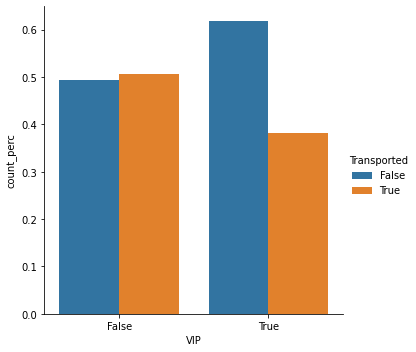

In [69]:
g = sns.catplot(
    data=dfx2,
    kind='bar',
    x='VIP',
    y='count_perc',
    hue='Transported',
)

g

**Note**

This results suggest that the category 'VIP' does have an influence on the Transportation

## RoomService, FoodCourt, ShoppingMall, Spa, VRDeck
Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

In [73]:
dftr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float32
 8   FoodCourt     8510 non-null   float32
 9   ShoppingMall  8485 non-null   float32
 10  Spa           8510 non-null   float32
 11  Name          8693 non-null   object 
 12  Transported   8693 non-null   object 
dtypes: float32(4), float64(1), object(8)
memory usage: 747.2+ KB


In [76]:
dfx = pd.melt(
    dftr,
    id_vars=['PassengerId'],
    value_vars=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa']
)

In [ ]:
pd.merge(
    dfx,
    dftx,
)

In [ ]:
sns.catplot(
    data=dfx,
    x='variable',
    y='value',
    hue=''
)

### RoomService

### FoodCourt

### ShoppingMall

### Spa, VRDeck

### VRDeck

## Name
The first and last names of the passenger.

## Transported
Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


# Header 1

# *Notes*

---

---